In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

In [3]:
sub = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/boxes.csv', encoding='utf-8', index_col=0)
sub['delivered_at'] = pd.to_datetime(sub['delivered_at'])
sub.head(2)

,subscription_id,box_id,delivered_at,started_week,count_boxes,product,channel
1,1000001,US3598,2013-01-14,2013-W03,1,type1,channel1
2,1000001,US3899,2013-01-21,2013-W03,2,type1,channel1


In [4]:
del_cnt = sub[['delivered_at','box_id']].groupby('delivered_at').agg('count')
del_cnt.index =pd.to_datetime(del_cnt.index)

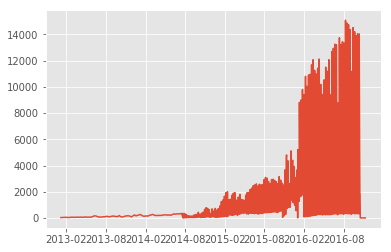

In [5]:
plt.plot(del_cnt)
plt.show()

In [6]:
last_purchase_dist = sub[['subscription_id','delivered_at','count_boxes']].groupby(['subscription_id']).agg({'delivered_at':[np.min,np.max],'count_boxes':np.max})
last_purchase_dist.head()
last_purchase_dist['purchase_gap_maxmin'] = last_purchase_dist['delivered_at']['amax'] - last_purchase_dist['delivered_at']['amin']
last_purchase_dist[last_purchase_dist['purchase_gap_maxmin'] == '0 days'].head()
# so we have approx 65% customers as repeat customers

count_boxes delivered_at            purchase_gap_maxmin
                       amax         amin       amax                    
subscription_id                                                        
1000002                   1   2013-01-28 2013-01-28              0 days
1000003                   1   2013-01-14 2013-01-14              0 days
1000006                   1   2013-01-14 2013-01-14              0 days
1000014                   1   2013-01-07 2013-01-07              0 days
1000017                   1   2013-01-07 2013-01-07              0 days

In [196]:
##last_purchase_dist = sub[['subscription_id','delivered_at','count_boxes','channel']].groupby(['subscription_id','channel']).agg({'delivered_at':[np.min,np.max],'count_boxes':np.max})
#Lets check whether a customer belongs to multiple channels
#pd.unique(pd.get_dummies(last_purchase_dist.reset_index()['channel']).sum(axis = 1))

## verify whether multiple customers 
# measuring distributon across channels
#pd.get_dummies(last_purchase_dist.reset_index()['channel']).sum(axis = 0)*100/pd.get_dummies(last_purchase_dist.reset_index()['channel']).sum(axis = 0).sum()

In [7]:
from datetime import datetime
today = datetime.today().replace(day = 7, month=11, year = 2016,hour=0,minute=0,second=0,microsecond=0)
today
last_purchase_dist['time_since_last_purchase']=last_purchase_dist['delivered_at']['amax'].apply(lambda x: today - x)

In [8]:
last_purchase_dist.head()

count_boxes delivered_at            purchase_gap_maxmin  \
                       amax         amin       amax                       
subscription_id                                                           
1000001                   3   2013-01-14 2013-01-28             14 days   
1000002                   1   2013-01-28 2013-01-28              0 days   
1000003                   1   2013-01-14 2013-01-14              0 days   
1000004                   2   2013-01-21 2013-01-28              7 days   
1000005                   3   2013-01-14 2013-01-28             14 days   

                time_since_last_purchase  
                                          
subscription_id                           
1000001                        1379 days  
1000002                        1379 days  
1000003                        1393 days  
1000004                        1379 days  
1000005                        1379 days

In [9]:
pd.DataFrame(last_purchase_dist.to_records()).columns

Index([u'subscription_id', u'('count_boxes', 'amax')',
       u'('delivered_at', 'amin')', u'('delivered_at', 'amax')',
       u'('purchase_gap_maxmin', '')', u'('time_since_last_purchase', '')'],
      dtype='object')

In [127]:
#TBD later
#df = pd.concat([last_purchase_dist, pd.get_dummies(last_purchase_dist['channel'])], axis=1)
#df.head()

In [10]:
#TBD later
#sub[['subscription_id','delivered_at']].groupby('subscription_id')['delivered_at'].apply(lambda x: list(x))

In [10]:
grouped = sub[['subscription_id','delivered_at']].groupby('subscription_id')

In [11]:
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing

def tmpFunc(df):
    return (df['subscription_id'].iloc[0],df['delivered_at'].nlargest(2).min())
    
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.DataFrame(retLst,columns=['subscription_id','2nd_last_transaction_date'])
df_temp = applyParallel(grouped, tmpFunc)

In [92]:
df_temp.set_index('subscription_id',inplace=True)
final_merge = pd.merge(last_purchase_dist,df_temp,how='inner',left_index=True,right_index=True)
final_merge.head(2)

,"(count_boxes, amax)","(delivered_at, amin)","(delivered_at, amax)","(purchase_gap_maxmin, )","(time_since_last_purchase, )",2nd_last_transaction_date
subscription_id,,,,,,
1000001,3,2013-01-14,2013-01-28,14 days,1379 days,2013-01-21
1000002,1,2013-01-28,2013-01-28,0 days,1379 days,2013-01-28


In [134]:
cancels = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/cancels.csv',encoding='utf-8')
cancels.set_index('subscription_id', inplace=True)
cancels['canceled_at'] = pd.to_datetime(cancels['canceled_at'])
cancels['cancelled'] = pd.Series(1, index=cancels.index)
final_merge = pd.merge(final_merge,cancels,how='left',left_index=True,right_index=True)

In [94]:
pauses = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/pauses.csv',encoding='utf-8')
pauses['pause_start'] = pd.to_datetime(pauses['pause_start'])
pauses['pause_end'] = pd.to_datetime(pauses['pause_end'])
pauses['pause_gap'] = pauses['pause_end'] - pauses['pause_start']
pauses['pause_cnt'] = pd.Series(1, index=pauses.index)
pauses.head()

,subscription_id,pause_start,pause_end,pause_gap,pause_cnt
0,1000003,2013-06-10,2013-06-16,6 days,1
1,1000003,2013-06-17,2013-06-23,6 days,1
2,1000003,2013-06-24,2013-06-30,6 days,1
3,1000009,2013-02-04,2013-02-10,6 days,1
4,1000009,2013-02-11,2013-02-17,6 days,1


In [95]:
#list(pd.unique(pauses[pauses['pause_gap']!='6 days']['subscription_id']))

In [96]:
##commenting as of now once i get an answer from the business to take a call on the data imputation for the following subscription ids
#last_purchase_dist[last_purchase_dist.index.isin(list(pd.unique(pauses[pauses['pause_gap']!='6 days']['subscription_id'])))]

## taking the above assumption
pauses = pauses[pauses['pause_gap']!='-360 days']

In [97]:
pauses_woseasonality = pauses.groupby('subscription_id').agg({'pause_cnt':'sum'})
## adding seasonality factors later on pauses
final_merge = pd.merge(final_merge,pauses_woseasonality,how='left',left_index=True,right_index=True)

In [103]:
final_merge.head()
###lets rename columns to make things more simple

,"(count_boxes, amax)","(delivered_at, amin)","(delivered_at, amax)","(purchase_gap_maxmin, )","(time_since_last_purchase, )",2nd_last_transaction_date,delivery_weekday,canceled_at,cancelled,pause_cnt
subscription_id,,,,,,,,,,
1000001,3,2013-01-14,2013-01-28,14 days,1379 days,2013-01-21,3.0,2013-01-29,1.0,NaN
1000002,1,2013-01-28,2013-01-28,0 days,1379 days,2013-01-28,3.0,2013-01-30,1.0,NaN
1000003,1,2013-01-14,2013-01-14,0 days,1393 days,2013-01-14,3.0,2013-06-03,1.0,3.0
1000004,2,2013-01-21,2013-01-28,7 days,1379 days,2013-01-21,3.0,2013-01-28,1.0,NaN
1000005,3,2013-01-14,2013-01-28,14 days,1379 days,2013-01-21,3.0,2013-01-30,1.0,NaN


In [104]:
errors = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/errors.csv',encoding='utf-8')
errors['created_at'] = pd.to_datetime(errors['created_at'])
errors['error_cnt'] = pd.Series(1, index=errors.index)
errors_woseasonality = errors.groupby('subscription_id').agg({'error_cnt':'sum'})

In [105]:
final_merge = pd.merge(final_merge,errors_woseasonality,how='left',left_index=True,right_index=True)
#final_merge.loc[final_merge.error_cnt>0].sort_values('error_cnt',ascending=False).head()

In [108]:
# convert days to integer and rename columns for better understanding
final_merge.columns = ['box_cnt','min_del_date','max_del_date','time_bw_purchases','time_since_last_purchase',
                       '2nd_last_transaction_date','delivery_weekday','canceled_at','cancelled','pause_cnt','error_cnt']

In [136]:
final_merge['time_bw_last2_purchases'] = final_merge['max_del_date'] - final_merge['2nd_last_transaction_date']
final_merge['time_bw_pur_can'] = final_merge['canceled_at'] - final_merge['max_del_date']
final_merge.head()

,box_cnt,min_del_date,max_del_date,time_bw_purchases,time_since_last_purchase,2nd_last_transaction_date,delivery_weekday,canceled_at,cancelled,pause_cnt,error_cnt,time_bw_last2_purchases,time_bw_pur_can
subscription_id,,,,,,,,,,,,,
1000001,3,2013-01-14,2013-01-28,14,1379,2013-01-21,3.0,2013-01-29,1.0,NaN,NaN,7,1 days
1000002,1,2013-01-28,2013-01-28,0,1379,2013-01-28,3.0,2013-01-30,1.0,NaN,NaN,0,2 days
1000003,1,2013-01-14,2013-01-14,0,1393,2013-01-14,3.0,2013-06-03,1.0,3.0,NaN,0,140 days
1000004,2,2013-01-21,2013-01-28,7,1379,2013-01-21,3.0,2013-01-28,1.0,NaN,NaN,7,0 days
1000005,3,2013-01-14,2013-01-28,14,1379,2013-01-21,3.0,2013-01-30,1.0,NaN,NaN,7,2 days


In [145]:
final_merge['time_bw_purchases'] = final_merge['time_bw_purchases'].dt.days
final_merge['time_since_last_purchase'] = final_merge['time_since_last_purchase'].dt.days
final_merge['time_bw_last2_purchases'] = final_merge['time_bw_last2_purchases'].dt.days
final_merge['time_bw_pur_can'] = final_merge['time_bw_pur_can'].dt.days
final_merge.loc[final_merge.pause_cnt.isnull(),'pause_cnt'] = 0
final_merge.loc[final_merge.error_cnt.isnull(),'error_cnt'] = 0
final_merge.head()

,box_cnt,min_del_date,max_del_date,time_bw_purchases,time_since_last_purchase,2nd_last_transaction_date,delivery_weekday,canceled_at,cancelled,pause_cnt,error_cnt,time_bw_last2_purchases,time_bw_pur_can
subscription_id,,,,,,,,,,,,,
1000001,3,2013-01-14,2013-01-28,14,1379,2013-01-21,3.0,2013-01-29,1.0,0.0,0.0,7,1.0
1000002,1,2013-01-28,2013-01-28,0,1379,2013-01-28,3.0,2013-01-30,1.0,0.0,0.0,0,2.0
1000003,1,2013-01-14,2013-01-14,0,1393,2013-01-14,3.0,2013-06-03,1.0,3.0,0.0,0,140.0
1000004,2,2013-01-21,2013-01-28,7,1379,2013-01-21,3.0,2013-01-28,1.0,0.0,0.0,7,0.0
1000005,3,2013-01-14,2013-01-28,14,1379,2013-01-21,3.0,2013-01-30,1.0,0.0,0.0,7,2.0


In [131]:
#final_merge.drop(['min_del_date','max_del_date','2nd_last_transaction_date'],axis=1,inplace=True)

box_cnt                               int64
min_del_date                 datetime64[ns]
max_del_date                 datetime64[ns]
time_bw_purchases                     int64
time_since_last_purchase              int64
2nd_last_transaction_date    datetime64[ns]
delivery_weekday                    float64
canceled_at                          object
cancelled                          category
pause_cnt                           float64
error_cnt                           float64
time_bw_last2_purchases               int64
dtype: object

In [141]:
final_merge.loc[final_merge.cancelled.isnull(),'cancelled'] = 0
final_merge["cancelled"] = final_merge["cancelled"].astype('category')
final_merge['cancelled'].value_counts()

1.0    313660
0.0     81723
Name: cancelled, dtype: int64

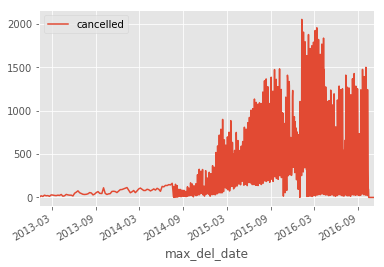

In [153]:
final_merge['cancelled'] = pd.to_numeric(final_merge['cancelled'])
final_merge.groupby('max_del_date').agg({'cancelled':np.sum}).plot()

In [159]:
final_merge.loc[final_merge.max_del_date > '2016-01-01'].shape

(258447, 13)

(136935, 13)


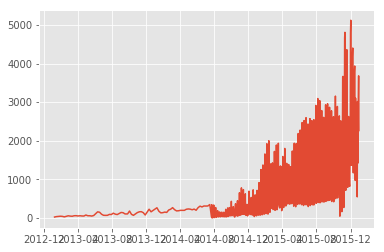

In [303]:
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing

#Lets take today date = '2016-01-01'
today = datetime.today().replace(day = 1, month=1, year = 2016,hour=0,minute=0,second=0,microsecond=0)
print final_merge.loc[final_merge.max_del_date < today].shape
sub = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/boxes.csv', encoding='utf-8', index_col=0)
sub['delivered_at'] = pd.to_datetime(sub['delivered_at'])
sub = sub.loc[sub.delivered_at<today]
del_cnt = sub[['delivered_at','box_id']].groupby('delivered_at').agg('count')
del_cnt.index =pd.to_datetime(del_cnt.index)
plt.plot(del_cnt)
plt.show()
last_purchase_dist = sub[['subscription_id','delivered_at','count_boxes']].groupby(['subscription_id']).agg({'delivered_at':[np.min,np.max],'count_boxes':np.max})
last_purchase_dist.head()
last_purchase_dist['purchase_gap_maxmin'] = last_purchase_dist['delivered_at']['amax'] - last_purchase_dist['delivered_at']['amin']
last_purchase_dist[last_purchase_dist['purchase_gap_maxmin'] == '0 days'].head()
last_purchase_dist['time_since_last_purchase']=last_purchase_dist['delivered_at']['amax'].apply(lambda x: today - x)
last_purchase_dist.head()
# so we have approx 65% customers as repeat customers

def tmpFunc(df):
    return (df['subscription_id'].iloc[0],df['delivered_at'].nlargest(2).min())
    
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count()-1)(delayed(func)(group) for name, group in dfGrouped)
    return pd.DataFrame(retLst,columns=['subscription_id','2nd_last_transaction_date'])

grouped = sub[['subscription_id','delivered_at']].groupby('subscription_id')
df_temp = applyParallel(grouped, tmpFunc)
df_temp.set_index('subscription_id',inplace=True)
train_merge = pd.merge(last_purchase_dist,df_temp,how='inner',left_index=True,right_index=True)
train_merge.head(2)
cancels = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/cancels.csv',encoding='utf-8')
cancels.set_index('subscription_id', inplace=True)
cancels['canceled_at'] = pd.to_datetime(cancels['canceled_at'])
cancels = cancels.loc[cancels.canceled_at<today]
cancels['cancelled'] = pd.Series(1, index=cancels.index)
train_merge = pd.merge(train_merge,cancels,how='left',left_index=True,right_index=True)
pauses = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/pauses.csv',encoding='utf-8')
pauses['pause_start'] = pd.to_datetime(pauses['pause_start'])
pauses['pause_end'] = pd.to_datetime(pauses['pause_end'])
pauses = pauses.loc[(pauses.pause_start<today) | (pauses.pause_end<today)]
pauses['pause_gap'] = pauses['pause_end'] - pauses['pause_start']
pauses['pause_cnt'] = pd.Series(1, index=pauses.index)
pauses = pauses[pauses['pause_gap']!='-360 days']
pauses.head()
pauses_woseasonality = pauses.groupby('subscription_id').agg({'pause_cnt':'sum'})
train_merge = pd.merge(train_merge,pauses_woseasonality,how='left',left_index=True,right_index=True)
errors = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/errors.csv',encoding='utf-8')
errors['created_at'] = pd.to_datetime(errors['created_at'])
errors = errors.loc[errors.created_at<today]
errors['error_cnt'] = pd.Series(1, index=errors.index)
errors_woseasonality = errors.groupby('subscription_id').agg({'error_cnt':'sum'})
train_merge = pd.merge(train_merge,errors_woseasonality,how='left',left_index=True,right_index=True)
# convert days to integer and rename columns for better understanding
train_merge.columns = ['box_cnt','min_del_date','max_del_date','time_bw_purchases','time_since_last_purchase',
                       '2nd_last_transaction_date','delivery_weekday','canceled_at','cancelled','pause_cnt','error_cnt']
train_merge['time_bw_last2_purchases'] = train_merge['max_del_date'] - train_merge['2nd_last_transaction_date']
train_merge['time_bw_pur_can'] = train_merge['canceled_at'] - train_merge['min_del_date']

#train_merge.head()
train_merge['time_bw_purchases'] = train_merge['time_bw_purchases'].dt.days
train_merge['time_since_last_purchase'] = train_merge['time_since_last_purchase'].dt.days
train_merge['time_bw_last2_purchases'] = train_merge['time_bw_last2_purchases'].dt.days
train_merge['time_bw_pur_can'] = train_merge['time_bw_pur_can'].dt.days
train_merge.loc[train_merge.pause_cnt.isnull(),'pause_cnt'] = 0
train_merge.loc[train_merge.error_cnt.isnull(),'error_cnt'] = 0
#train_merge.head()
train_merge.loc[train_merge.cancelled.isnull(),'cancelled'] = 0
train_merge["cancelled"] = train_merge["cancelled"].astype('category')
train_merge.drop(['min_del_date','max_del_date','2nd_last_transaction_date','canceled_at','delivery_weekday'],axis=1,inplace=True)

In [319]:
train_merge.loc[train_merge['time_bw_pur_can'].isnull(),'time_bw_pur_can'] = train_merge.loc[train_merge['time_bw_pur_can'].isnull()==False,'time_bw_pur_can'].mean()

In [407]:
#train_merge.loc[train_merge['time_bw_pur_can']<0,'time_bw_pur_can'] = train_merge.loc[train_merge['time_bw_pur_can']>-5,'time_bw_pur_can'].mean()
##approx time between purchase and canellation

##view all the customers which have cancelled date far earlier than purchase date - These might be the customers
#last_purchase_dist.loc[last_purchase_dist.index.isin(train_merge.loc[train_merge['time_bw_pur_can']<-5].index),]
#so remove all these customers who have purhase only once



,box_cnt,time_bw_purchases,time_since_last_purchase,cancelled,pause_cnt,error_cnt,time_bw_last2_purchases
subscription_id,,,,,,,
1000001,3.000000,14.000000,1068.000000,1.0,0.0,0.0,7
1000002,1.000000,0.000000,1068.000000,1.0,0.0,0.0,0
1000003,1.000000,0.000000,1082.000000,1.0,3.0,0.0,0
1000004,2.000000,7.000000,1068.000000,1.0,0.0,0.0,7
1000005,3.000000,14.000000,1068.000000,1.0,0.0,0.0,7
1000006,1.000000,0.000000,1082.000000,1.0,0.0,0.0,0
1000007,2.000000,7.000000,1082.000000,1.0,0.0,0.0,7
1000008,4.000000,21.000000,1054.000000,1.0,0.0,0.0,7
1000009,3.000000,77.000000,998.000000,1.0,32.0,0.0,7


In [383]:
train_merge.drop('time_bw_pur_can',axis=1,inplace=True)

In [384]:
y = train_merge['cancelled'].as_matrix()
cols = set(train_merge.columns)
cols.remove('cancelled')
X = train_merge[list(cols)].as_matrix().astype(np.float)
# We use the prepocessing module of scikit-learn to normalize our features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 167614 observations and 6 features
Unique target labels: [ 0.  1.]


In [403]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [404]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
clf = logistic.fit(X_train,y_train)
#print 'score Scikit learn: ', clf.score(X_test,y_test)

In [405]:
import numpy as np
np.set_printoptions(suppress=True) 
pd.DataFrame(clf.predict_proba(X_test))
y_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred, sample_weight=None)

###seems to very accurate classifier

array([[12807,     0],
       [    0, 37478]])

In [345]:
print cols
print logistic.coef_

set(['time_bw_pur_can', 'time_bw_purchases', 'error_cnt', 'box_cnt', 'pause_cnt', 'time_bw_last2_purchases', 'time_since_last_purchase'])
[[ 0.5466721   0.03340444  0.07590658 -8.2964889  -0.47180634  0.03856606
   0.68130803]]


In [333]:
from sklearn.model_selection import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),shuffle=True)
    y_pred = y.copy()

    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN

def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))


from sklearn.metrics import confusion_matrix

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
]

# Pyplot code not included to reduce clutter
from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

In [ ]:
#more features to add like average time between purchases